In [9]:
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch import nn
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt

import utils
import utils.data, utils.ML, utils.models
from utils.models import number_of_parameters

# Load data

In [41]:
# various transforms:

transform_CIFAR = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

alexnet_preprocessing = models.AlexNet_Weights.IMAGENET1K_V1.transforms()

transform_upscale = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()])

In [39]:
alexnet_preprocessing

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [42]:
batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='/Users/lucas/Documents/Data/', train=True, download=False, transform=alexnet_preprocessing)
testset = torchvision.datasets.CIFAR10(root='/Users/lucas/Documents/Data/', train=False, download=False, transform=alexnet_preprocessing)

# split training data into train and validation sets:
train_split, val_split = torch.utils.data.random_split(
    trainset, [40000, 10000],
    generator=torch.Generator().manual_seed(42))

# Create data loaders.
train_dataloader = torch.utils.data.DataLoader(train_split, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_split, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

dataloaders = [train_dataloader, val_dataloader, test_dataloader]

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
ImageNet_classes = utils.data.get_ImageNet_classes()

# Test data loading with no rescaling (for plotting):
testset_clean = torchvision.datasets.CIFAR10(root='/Users/lucas/Documents/Data/', train=False, download=False, transform=transform_upscale)
test_dataloader_clean = torch.utils.data.DataLoader(testset_clean, batch_size=batch_size)

# Run AlexNet on upsampled CIFAR images

In [52]:
# Load model:

alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

wire-haired fox terrier             | confidence: 6.94%
patas, hussar monkey, Erythrocebus  | confidence: 5.67%
Eskimo dog, husky                   | confidence: 4.66%
macaque                             | confidence: 4.15%
Sussex spaniel                      | confidence: 3.62%


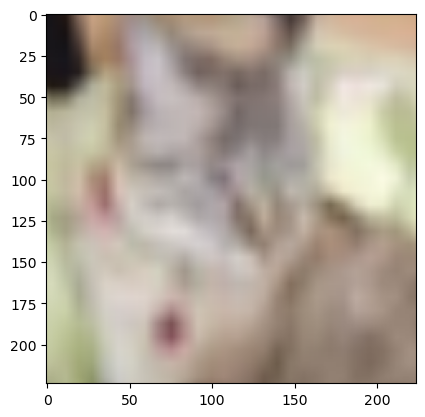

In [51]:
X, y = next(iter(test_dataloader))  # images that have be upscaled/preprocessed using AlexNet preprocessing
X_clean, _ = next(iter(test_dataloader_clean))  # for plotting

with torch.no_grad():
    out = alexnet(X)
softmax = F.softmax(out, dim=1).detach().numpy()

i = 8  # select image
    
# top-5 results:
softmax_ = softmax[i]
asort = np.argsort(softmax_)[::-1]
idxs = asort[:5]
confs = softmax_[idxs]

for pred in zip(idxs, confs):
    print(f'{ImageNet_classes[pred[0]][:35]:<35} | confidence: {pred[1]*100:.2f}%')

plt.figure()
plt.imshow(np.transpose(X_clean[i], (1, 2, 0)));

# Fine-tune Alexnet on CIFAR

In [53]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 